# Import

In [1]:
import numpy as np
import sys
sys.path.append('C:/ProgramData/Anaconda2/Lib/site-packages/fatiando')
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism, sphere
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
from numpy.linalg import inv
import functions_eq_mag as fc
%matplotlib inline

C:\ProgramData\Anaconda2\Lib\site-packages\fatiando\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (50, 50)
N = shape[0]*shape[1]
xi, yi, zi = gridder.regular(area, shape, z=-900.)

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (50, 50)
Nj = shapej[0]*shapej[1]
xj, yj, zj = gridder.regular(areaj, shapej, z=0)

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 0], [2000, 0]]
verts2 = [[-2000, 2000], [0, 2000], [0, 6000], [-2000, 6000]]
model_prism = [mesher.PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,0]}),
            mesher.PolygonalPrism(verts2, 900., 1500., props={'magnetization':[2,2,0]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [mesher.Sphere(xc, yc, zc, R, props={'magnetization':[2,2,0]})]

In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(10.)
dec0 = np.deg2rad(37.)
inc = np.deg2rad(10.)
dec = np.deg2rad(37.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
tf_prism = polyprism.tf(xi, yi, zi, model_prism, inc0, dec0)
tf_sphere = sphere.tf(xi, yi, zi, model_sphere, inc0, dec0)
tf = tf_prism + tf_sphere
tf = utils.contaminate(tf, 0.02, seed=0, percent=True)

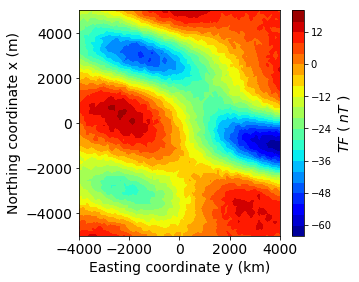

In [5]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [6]:
# Calculo da matriz de sensibilidade
s = time()
p_c, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
e = time()
tcpu = e - s
print tcpu

2.1141592


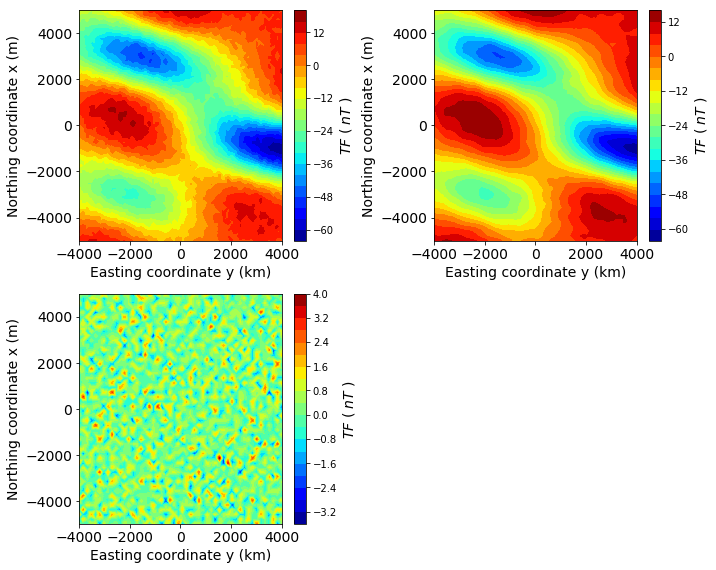

In [7]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,tf_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-tf_c
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

## Parameter Plot

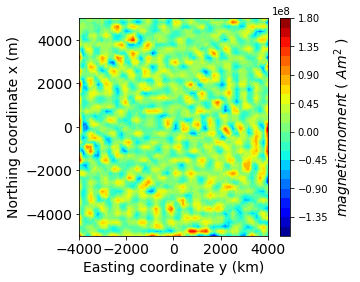

In [8]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

# Conjugate Gradient Least Square

### BCCB  matrix-vector product with Linear CGLS implementation - no conditioning

In [9]:
w = time()
itmax = 50
p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print tcpu

0.0747917


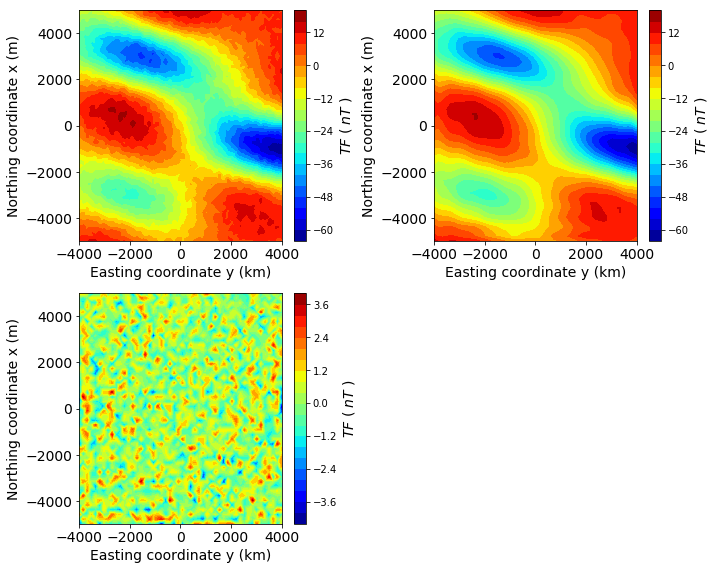

In [10]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.tricontourf(yi,xi,tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

plt.subplot(222)
plt.tricontourf(yi,xi,dobs_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)

delta_tf = tf-dobs_cgls
plt.subplot(223)
plt.tricontourf(yi,xi,delta_tf,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

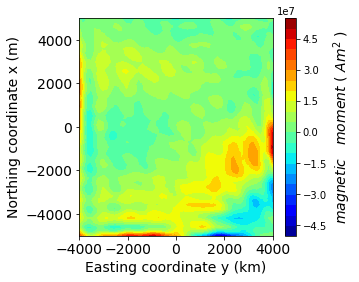

In [11]:
plt.figure(figsize=(5,4))

plt.tricontourf(yi,xi,p_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi),np.max(yi))
plt.ylim(np.min(xi),np.max(xi))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
plt.tight_layout(True)
#plt.savefig('figures/classic_fast.png', dpi=300)

## CGLS Convergence

In [12]:
itmax = np.arange(1,50,1)
res_list_ls = []
for k in itmax:
    p_cgls,dobs_cgls = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls = np.linalg.norm(tf-dobs_cgls)
    res_list_ls.append(norm_res_ls)

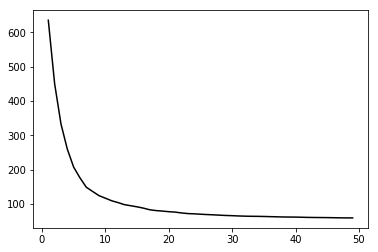

In [13]:
plt.plot(itmax,res_list_ls, 'k-')